In [1]:
%pylab inline
import numpy as np

import networkx as nx

from utility import ER_GNP, make_SBM, uniform_weight_edges

from sis import simulate_SIS, get_p_curve, get_p_curves, make_raster_plots

import importlib

from manage import (
    rank_by_evec,
    decrease_nodes_weights,
    decrease_top_nodes_weights,
    manage_nodes,
)

Populating the interactive namespace from numpy and matplotlib


# 1. Make Network to Study

In [2]:
np.random.seed(111)

In [3]:
def get_community_4(comm_type):
    PI = None
    if comm_type == "line":
        PI = get_community_line(4)
    if comm_type == "star":
        PI = np.array([[.1,.05,.05,.05],
                      [.05,.1,.00,.00],
                      [.05,.00,.1,.00],
                      [.05,.00,.00,.1]])
    if comm_type == "square":
        PI = np.array([[.1,.05,.00,.05],
                      [.05,.1,.05,.00],
                      [.00,.05,.1,.05],
                      [.05,.00,.05,.1]])
    if comm_type == "closed":
        PI = np.array([[.1,.05,.05,.05],
                      [.05,.1,.05,.05],
                      [.05,.05,.1,.05],
                      [.05,.05,.05,.1]])
    return PI

def get_community_line(n):
    main = np.full((n, ), 0.1)
    sub = np.full((n-1, ), 0.05)
    sup = np.full((n-1, ), 0.05)
    return np.diag(main, k=0) + np.diag(sub, k=1) + np.diag(sup, k=-1)
    

    # doh the U and square have the same ecol - different social!
def get_community_2(comm_type):
    PI = None
    if comm_type == "open": # the U
        PI = np.array([[.1,.05],
                      [.05,.1,]])
    if comm_type == "closed": # the square or O
         PI = np.array([[.1,.05],
                      [.05,.1,]])
    return PI


def get_community(comm_type, n=4):
    scaling = 0.5
    if n == 4:
        return scaling * get_community_4(comm_type)
    if n == 2:
        return scaling * get_community_2(comm_type)
    if n > 4:
        if comm_type != "line":
            raise ValueError("comm type must be line for n > 4")
        return scaling * get_community_line(n)
    else:
        return None

def get_social_net(interaction_type):
    if interaction_type == 'open':
        A_social = np.array([[1,0],[0,1]])
    if interaction_type == 'closed':
        A_social = np.array([[1,1],[1,1]])
    
    return A_social # adjacency matrix of interactions



In [4]:
num_com = 2 # number communities
PI = np.array([[.1,.02],
                      [.02,.1,]])
N = 100*num_com # nodes
Ns = np.ones(num_com,dtype=int)*N/num_com
A,id_sets = make_SBM(Ns,PI)
A = uniform_weight_edges(A,.2)
lam = np.max(np.linalg.eigh(A)[0])
print(lam)


1.29593543389044


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

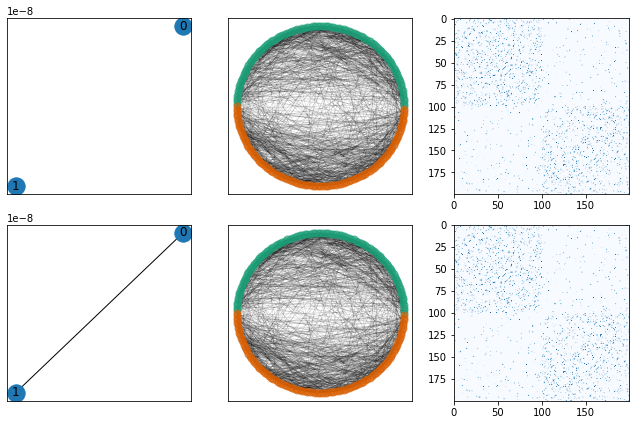

In [5]:
cmap = plt.get_cmap('Dark2')
colors = [cmap(i) for i in range(num_com)]
#colors = Pastel1#['b','r','g','y']

f1,ax = plt.subplots(2,3,figsize = (9,6))
for i, ct in enumerate(['open', 'closed']):
    
    # social network
    A_social = get_social_net(ct) # adjacency matrix of social network
    G_social = nx.to_networkx_graph(A_social, create_using=nx.Graph())
    pos = nx.circular_layout(G_social)
    nx.draw_networkx(G_social,pos, ax=ax[i, 0])

    # ecological network
    G = nx.to_networkx_graph(A,create_using=nx.Graph())
    pos = nx.circular_layout(G)
    for t,ids in enumerate(id_sets):
        nx.draw_networkx_nodes(G,pos,nodelist = ids,ax=ax[i, 1],node_size=50,node_color=colors[t],alpha=.6)
    #nx.draw_networkx_edges(G,pos,ax=ax[i, 1],edge_size=2,node_color='k',alpha=.2)   
    nx.draw_networkx_edges(G,pos,ax=ax[i, 1],width=.5,alpha=.2)   

    temp = ax[i, 2].imshow(A,cmap='Blues');

#cbar = plt.colorbar(temp);
plt.tight_layout()
savefig('figs/community_net_plot.pdf')

# Fully collective, independent, and random management

In [52]:
#management parameters

p = 0.7 # management effect
K_step = 5 # step 
KK = 200 # number of mitigations
#Ks = np.arange(0,KK,K_step)

manage_opts = {'p':p, # decrease the edge weights of selected nodes by p% (p=1 is the strongest management) 
               'online':True, # update ranking after each modification?
               'distributed':False, # compute rankings separately for different subgraphs,
               'budget_step':K_step 
              }


In [53]:
# random management

rank_opts = {'type':'random', # rank completely at random
             'budget':[KK],
             'control_id_sets':[np.arange(len(A))] # global control
            }
A_random,lams_random, Ks_random = manage_nodes(A,rank_opts,manage_opts)

In [54]:
# fully collective management

rank_opts['type'] = 'evec' # rank according to eigenvector centrality  - no 'info_id_sets' needed
A_collective,lams_collective, Ks_collective = manage_nodes(A,rank_opts,manage_opts)

In [55]:
# independent management

manage_opts = {'p':p, # decrease the edge weights of selected nodes by p% (p=1 is the strongest management) 
               'online':True, # update ranking after each modification?
               'distributed':True, # compute rankings separately for different subgraphs,
               'budget_step':K_step
              }

rank_opts = {'type':'distributed_evec',  
             'budget':np.repeat(int(ceil(KK / num_com)), num_com),
             'control_id_sets':id_sets,  
             'info_id_sets':id_sets
            }

A_independent,lams_independent, Ks_independent = manage_nodes(A,rank_opts,manage_opts)


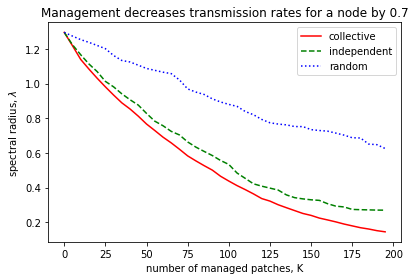

In [56]:
plt.plot(Ks_collective,lams_collective,'r-')
plt.plot(Ks_independent,lams_independent,'g--')
plt.plot(Ks_random,lams_random,'b:')

plt.legend(['collective','independent','random'])

plt.xlabel('number of managed patches, K')
plt.ylabel('spectral radius, $\lambda$')

plt.title('Management decreases transmission rates for a node by '+ str(manage_opts['p']));
plt.tight_layout();
plt.savefig('figs/node_management_SBM222'+str(num_com)+'.pdf')

# Coordinated management

In [11]:
# get ids of patches for social network neighbors

def get_info_ids(A_social):
    info_ids = []
    for i in range(len(id_sets)):
        neighbors_and_thy_self = where(A_social[i]>0)[0] # who is sharing
        info_ids.append(np.array(list(set().union(*[list(id_sets[c]) for c in neighbors_and_thy_self ]))))
    return info_ids

# A_social =   get_social_net('open')
# info_ids = get_info_ids(A_social)
# print(info_ids)

# A_social =   get_social_net('closed')
# info_ids = get_info_ids(A_social)
# print(info_ids)

In [12]:
# info sharing -- community minded folks but don't have a connection to their neighbors

manage_opts = {'p':p, # decrease the edge weights of selected nodes by p% (p=1 is the strongest management) 
               'online':True, # update ranking after each modification?
               'distributed':True, # compute rankings separately for different subgraphs,
               'budget_step':K_step
              }

rank_opts = {'type':'distributed_evec',  
             'budget':np.repeat(int(ceil(KK / num_com)), num_com),
             'control_id_sets':id_sets,  
             'info_id_sets':id_sets
            }

A_social = get_social_net('open') # there's no social network
rank_opts['info_id_sets'] = get_info_ids(A_social)
A_open,lams_open, Ks_open = manage_nodes(A,rank_opts,manage_opts)


In [13]:
# info sharing -- community minded folks AND WITH connections to their neighbors

A_social = get_social_net('closed') # there's no social network
rank_opts['info_id_sets'] = get_info_ids(A_social)
A_closed,lams_closed, Ks_closed = manage_nodes(A,rank_opts,manage_opts)


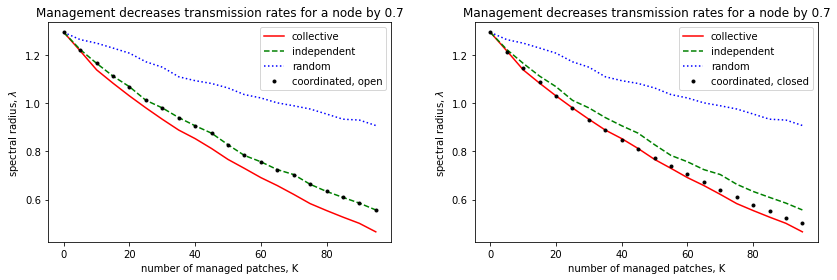

In [14]:
f1,ax = plt.subplots(1,2,figsize=(12,4));

ax[0].plot(Ks_collective,lams_collective,'r-')
ax[0].plot(Ks_independent,lams_independent,'g--')
ax[0].plot(Ks_random,lams_random,'b:')
ax[0].plot(Ks_open,lams_open,'k.')

ax[0].legend(['collective','independent','random','coordinated, open'])
ax[0].set_xlabel('number of managed patches, K')
ax[0].set_ylabel('spectral radius, $\lambda$')
ax[0].set_title('Management decreases transmission rates for a node by '+ str(manage_opts['p']));


ax[1].plot(Ks_collective,lams_collective,'r-')
ax[1].plot(Ks_independent,lams_independent,'g--')
ax[1].plot(Ks_random,lams_random,'b:')
ax[1].plot(Ks_closed,lams_closed,'k.')

ax[1].legend(['collective','independent','random','coordinated, closed'])
ax[1].set_xlabel('number of managed patches, K')
ax[1].set_ylabel('spectral radius, $\lambda$')
ax[1].set_title('Management decreases transmission rates for a node by '+ str(manage_opts['p']));


plt.tight_layout();
plt.savefig('figs/node_management_SBM222'+str(num_com)+'.pdf')


## differences in networks post-managmenet

We compare characteristics of independent to coordinated management

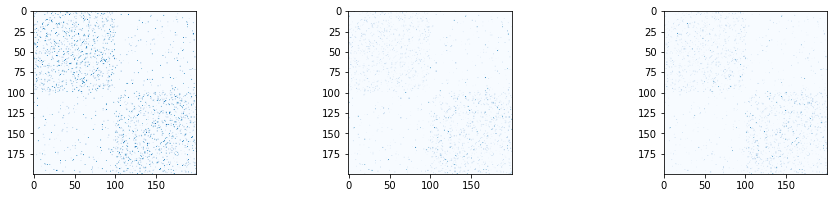

In [51]:
def make_scatters(ax,As):
    for t in range(len(As)):
        im = ax[t].imshow(As[t],cmap='Blues');
        #plt.set_colorbar(im);
    return
        

f1,ax = plt.subplots(1,3,figsize=(16,3));
# u vs sq before management -- not visible??
make_scatters(ax,[A, A_open, A_closed])

## Examine change in distributional impact

we have the patch level probability of occupancy by a new outbreak (near threshold) as 
$p_i \approx \gamma * \lambda / \beta u_i$ with $\mathbf u$ right eigen vector of $A$. 

This gives us a way to look at expected total "damage": $\gamma \lambda /\beta \sum_{i \in Manager} u_i$. We can compare this for globally-knowledgable/concerned manager vs locally-knowledgable/concerned. Note that because this is linear in $\gamma\lambda/\beta$ the _relative_ total damage among managers is given just by the sums of the eigenvalue entries.

In [29]:
def evec_impact(A):
    l, u = np.linalg.eigh(A)
    l_max_idx = np.argmax(l) # should be the last one at position len(l)-1
    u_max = u[:, l_max_idx]
    return np.array([abs(sum(u_max[i])) for i in id_sets])

def evec_dist(A):
    u = evec_impact(A)
    return np.array([i / sum(u) for i in u])

#id_sets

The **distribution of total damage across scenarios** for management strategies:



In [50]:
import pandas as pd  # for formatting

nets = [A, A_random, A_collective, A_independent, A_open, A_closed]
evec_dists = [evec_dist(a) for a in nets]
evec_impacts = [evec_impact(a) for a in nets]

df = pd.DataFrame(evec_dists, columns=["dist 1", "dist 2"], 
            index=["non-online", "non-online", "non-online", "non-online", "non-online", "non-online"])
df['strategy'] = [
    "original",
    "random",
    "collective",
       "independent",
    "coordinated open",
    "coordinated closed"
]
df[['strategy', 'dist 1', 'dist 2']].round(2)

df2 = pd.DataFrame(evec_impacts, columns=["impact 1", "impact 2"], 
            index=["non-online", "non-online", "non-online", "non-online", "non-online", "non-online"])
df2['strategy'] = [
    "original",
    "random",
    "collective",
       "independent",
    "coordinated open",
    "coordinated closed"
]

df2[['strategy', 'impact 1', 'impact 2']].round(2)
pd.concat([df.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)

,dist 1,dist 2,strategy,impact 1,impact 2,strategy
0,0.594224,0.405776,original,7.804035,5.329126,original
1,0.425784,0.574216,random,4.686633,6.320444,random
2,0.594044,0.405956,collective,7.528282,5.144661,collective
3,0.326093,0.673907,independent,3.643870,7.530462,independent
4,0.326093,0.673907,coordinated open,3.643870,7.530462,coordinated open
5,0.257010,0.742990,coordinated closed,2.964643,8.570482,coordinated closed


The **change in percentage of damage incurred** when changing management strategies:



In [18]:
# evec_impacts_percent = [evec_impact(A)/evec_impact(A)-1,
#         evec_impact(A_random)/evec_impact(A)-1,
#         evec_impact(A_collective)/evec_impact(A)-1,
#         evec_impact(A_independent)/evec_impact(A)-1,
#         evec_impact(A_open)/evec_impact(A) - 1,
#         evec_impact(A_closed)/evec_impact(A)-1
#        ]

# df = pd.DataFrame(evec_impacts_percent, columns=["mgr 1", "mgr 2"], 
#             index=["non-online", "non-online", "non-online", "non-online", "non-online", "non-online"])
# df['change in strategy'] = [
#     "independent to cooperative",
#     "collabrative to cooperative",
#     "independent to collabrative",
#        "independent to coordinated",
#     "top-down to coordinated",
#     "independent to collabrative"
# ]

# df[['change in strategy', 'mgr 1', 'mgr 2']].round(2)